# A robust fetal ECG detection method for abdominal recordings
## Marta Stefanelli - 84393A

In [44]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import resample, correlate, butter, filtfilt
from sklearn.decomposition import PCA

# Plot example of a14.csv

### What we are looking?
We are looking 4 different signals, each one captured by an electrod during a non-invasive abdominal ECG. Each signal is composed by the MECG and the FECG, our goal is to recognize the FECG by a robust pipeline. 

S1

In [45]:
def load_ecg_from_csv(csv_path):
    """
    Load PhysioNet Challenge 2013 ECG.
    Returns: signals (4 x N), fs (Hz), time (N,)
    """
    df = pd.read_csv(csv_path, header=0)
    df = df.iloc[1:].reset_index(drop=True)
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.dropna()
    time = df.iloc[:, 0].values
    signals = df.iloc[:, 1:].values.T
    dt = np.diff(time)
    fs = round(1 / np.median(dt))
    return signals, fs, time


# Plot 
def plot_ecg_signals(signals, time):
    """
    Plot 4 ECG channels in separate subplots and overlapped.
    """
    channels = signals.shape[0]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    global_min = signals.min()
    global_max = signals.max()

    # Separate subplots for each channel
    fig, axes = plt.subplots(channels, 1, figsize=(12, 10), sharex=True)
    for i in range(channels):
        axes[i].plot(time, signals[i], color=colors[i])
        axes[i].set_ylabel(f"ECG{i+1} (µV)")
        axes[i].set_ylim(global_min, global_max)
        axes[i].grid(True)
        axes[i].set_title(f"AECG Channel {i+1}")
    axes[-1].set_xlabel("Time (s)")
    fig.suptitle("AECG Signals (separate channels)", fontsize=14)
    plt.tight_layout()
    plt.show() # Rimosso plt.legend()

    # Overlapped plot of all channels
    plt.figure(figsize=(12,5))
    for i in range(channels):
        plt.plot(time, signals[i], color=colors[i], label=f"ECG{i+1}")
    plt.title("AECG Signals (overlapped)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

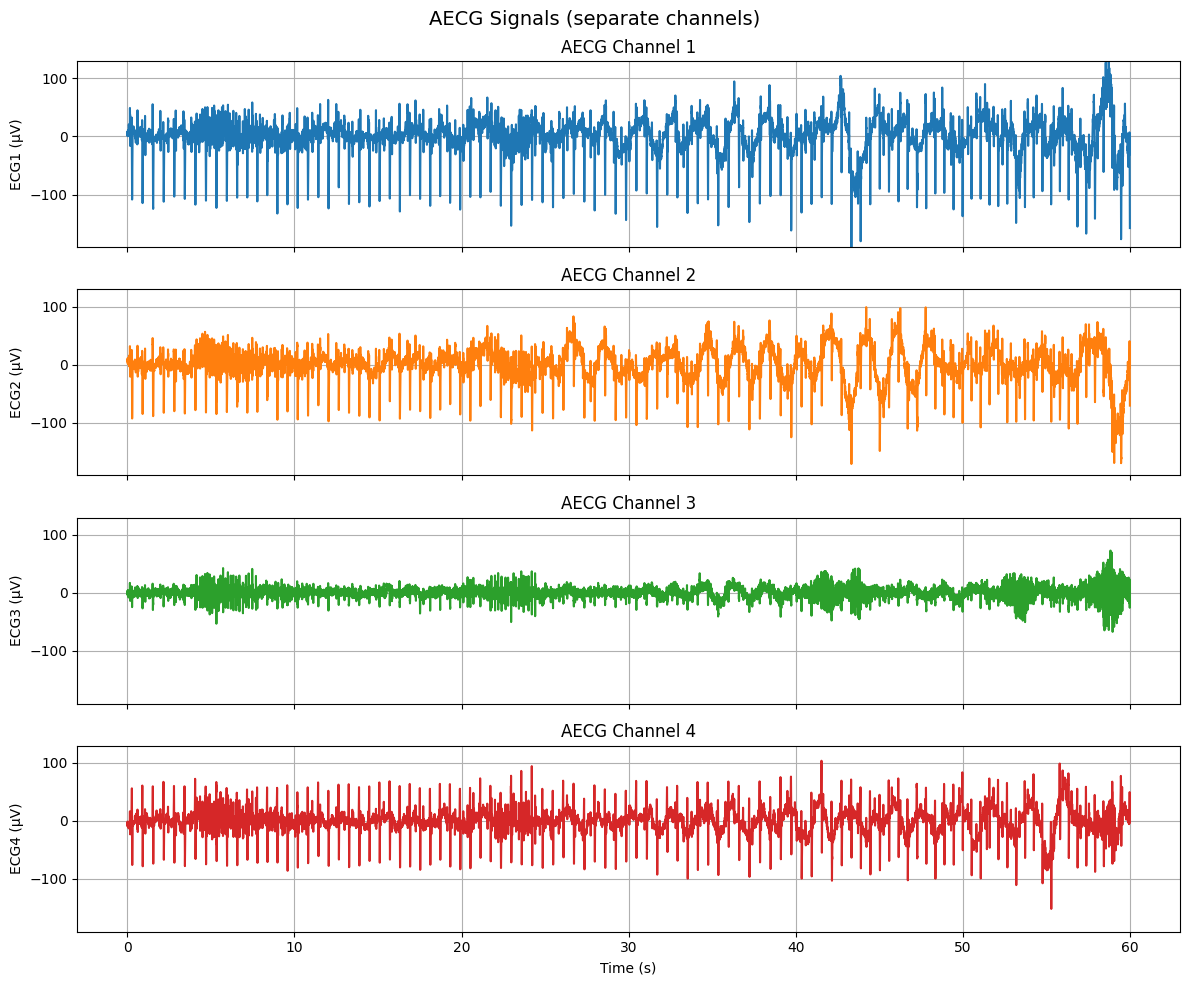

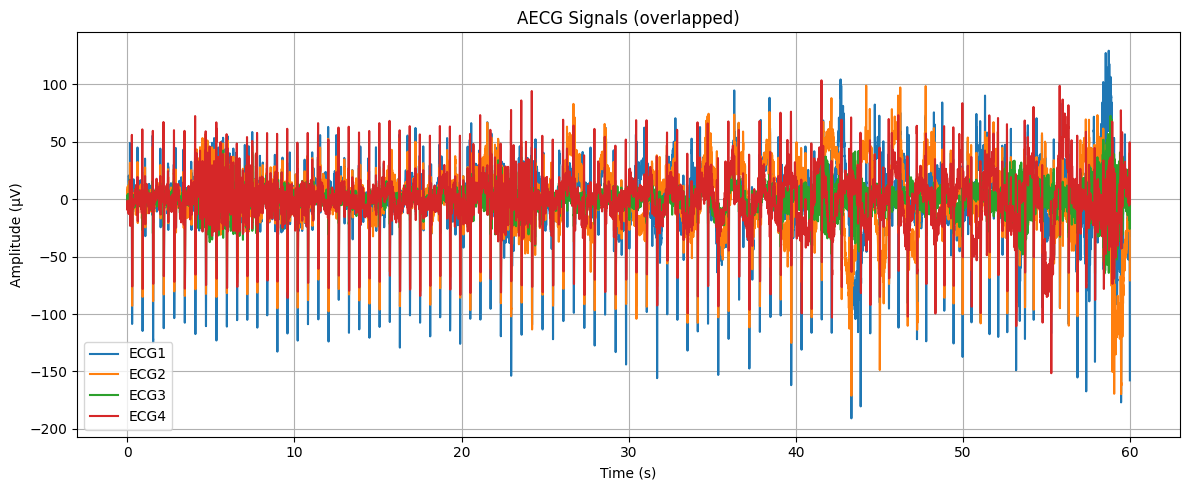

Estimated sampling frequency: 1000 Hz
Original signal S1 shape: (4, 60000)
Duration (s): 60.00


In [46]:
CSV_PATH = "a14.csv" 
signals, fs, time = load_ecg_from_csv(CSV_PATH)


S1 = signals.copy()

plot_ecg_signals(S1, time)

# 4. Stampa i messaggi informativi
print("Estimated sampling frequency:", fs, "Hz")
print("Original signal S1 shape:", S1.shape)
print(f"Duration (s): {S1.shape[1] / fs:.2f}")

This step is for the downloading of the autio of S1

In [47]:
import numpy as np
from scipy.io.wavfile import write as write_wav 

def sonify_ecg(signals, fs, channel_index=0, output_filename="ecg_sonified.wav"):
    """
    Sonify an ECG channel by increasing the signal frequency (pitch shift).
    
    Parameters:
    signals (array): ECG signals (channels x samples)
    fs (int): original sampling frequency
    channel_index (int): index of the channel to sonify (e.g., 0 for ECG1)
    output_filename (str): name of the WAV file to save
    """
    ecg_data = signals[channel_index]
    
    # Remove DC offset
    ecg_data = ecg_data - np.mean(ecg_data)
    
    # Target audio sampling frequency
    target_fs_audio = 44100 
    
    # Calculate upsampling factor
    factor = target_fs_audio / fs
    new_samples = int(len(ecg_data) * factor)
    
    # Upsample ECG to target audio sampling rate
    time_orig = np.arange(len(ecg_data))
    time_new = np.linspace(0, len(ecg_data) - 1, new_samples)
    ecg_upsampled = np.interp(time_new, time_orig, ecg_data)

    # Normalize to 16-bit audio range
    max_val = np.max(np.abs(ecg_upsampled))
    if max_val == 0:
        audio_data = np.zeros(new_samples, dtype=np.int16)
    else:
        audio_data = (ecg_upsampled / max_val * 32767).astype(np.int16) 

    # Save as WAV file
    write_wav(output_filename, target_fs_audio, audio_data)
    
    print(f"Audio file saved as: {output_filename} (Duration unchanged, pitch increased)")

# Settings
CHANNEL_TO_SONIFY = 0 
OUTPUT_FILE = "S1_ECG1_sonified_a14.wav"

print("\n--- Starting Sonification ---")
sonify_ecg(S1, fs, channel_index=CHANNEL_TO_SONIFY, output_filename=OUTPUT_FILE)
print("Sonification completed. Open the WAV file to hear the heartbeat.")



--- Starting Sonification ---
Audio file saved as: S1_ECG1_sonified_a14.wav (Duration unchanged, pitch increased)
Sonification completed. Open the WAV file to hear the heartbeat.


# Fase 1: Baseline wander remover

I use an high pass FIR filer with specific attributes: fixed cut-off frequency fc of 3 Hz at a sampling frequency of 400 Hz.

S1 -> S2

In [48]:
def highpass_fir(signals, fs=400, fc=3.0, numtaps=1001):
    """
    High-pass FIR baseline removal (linear phase).
    """
    nyq = fs / 2
    cutoff_norm = fc / nyq
    taps = signal.firwin(numtaps, cutoff_norm, pass_zero=False)
    filtered = signal.filtfilt(taps, [1.0], signals, axis=1)

    return filtered, taps 

def plot_filtered(signals, filtered, time, fc=3.0):
    """
    Plot per-channel comparison of original vs high-pass filtered signals,
    and also plot the filtered signals overlapped.
    """
    ch = signals.shape[0]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    
    fig, axes = plt.subplots(ch, 1, figsize=(12, 9), sharex=True)

    for i in range(ch):
        axes[i].plot(time, signals[i], label="Original", alpha=0.6, color=colors[i % len(colors)])
        axes[i].plot(time, filtered[i], label=f"Filtered (HP {fc} Hz)", linewidth=1.2, color='gray')
        axes[i].set_ylabel(f"ECG{i+1}")
        axes[i].grid(True)
        axes[i].set_title(f"Channel {i+1} Baseline Removal")
        axes[i].legend(loc='upper right')

    axes[-1].set_xlabel("Time (s)")
    fig.suptitle("Baseline Removal per Channel (Original vs Filtred)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 5))
    for i in range(ch):
        plt.plot(time, filtered[i], color=colors[i % len(colors)], label=f"ECG{i+1} (Filtered)")

    plt.title(f"Filtered signals (H-P at {fc} Hz) Overlapped")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_filter_response(taps, fs):
    """
    Calculates and plots the frequency response of an FIR filter.
    """
    w, h = signal.freqz(taps, worN=2000)
    
    freq_hz = w * fs / (2 * np.pi)
    mag_db = 20 * np.log10(np.abs(h))
    
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(freq_hz, mag_db)
    plt.title('FIR High-Pass Filter Frequency Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.ylim(-100, 5) 
    plt.grid(True, which='both', axis='both')
    plt.axvline(3.0, color='red', linestyle='--', label='Cutoff 3 Hz') 
    plt.axhline(-3, color='gray', linestyle=':', label='-3 dB (Cutoff Approximation)')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(freq_hz, np.unwrap(np.angle(h))) 
    plt.title('FIR Filter Phase Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid(True, which='both', axis='both')

    plt.tight_layout()
    plt.show()

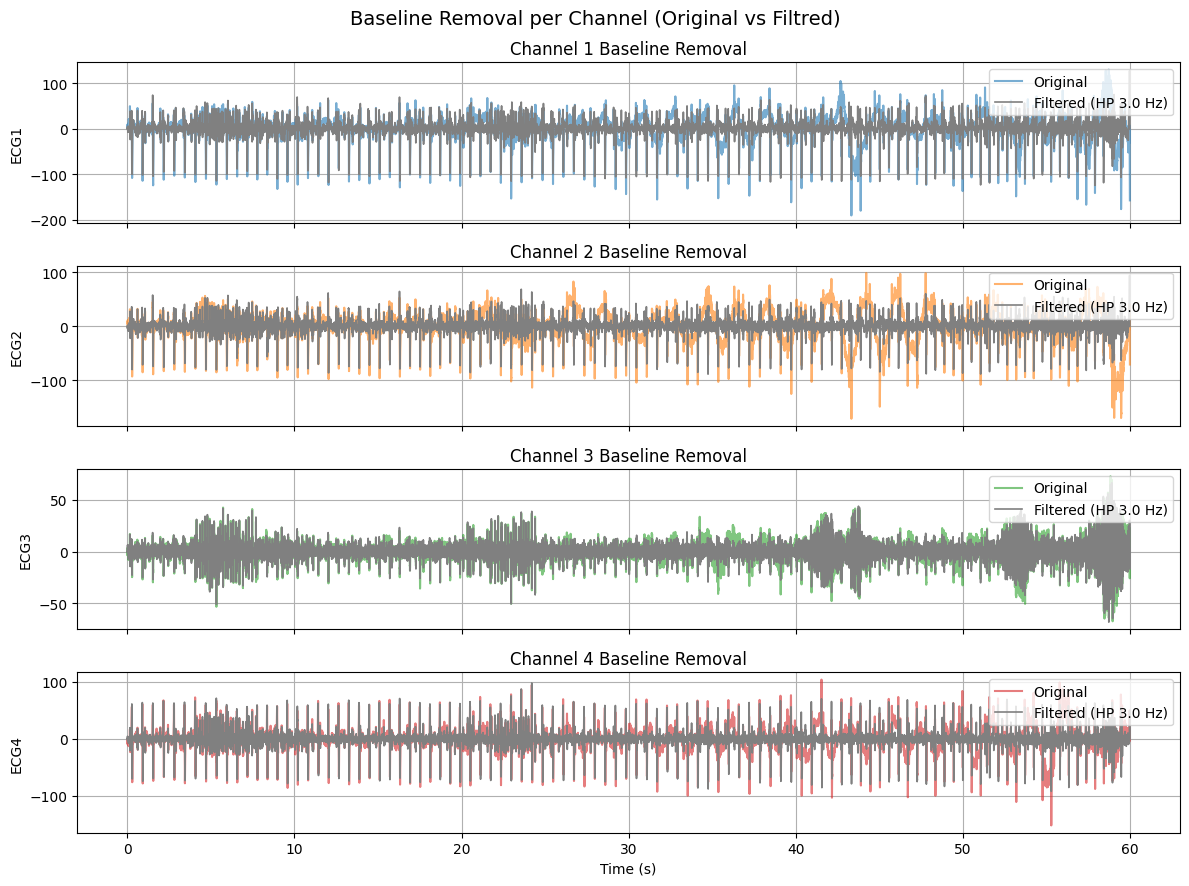

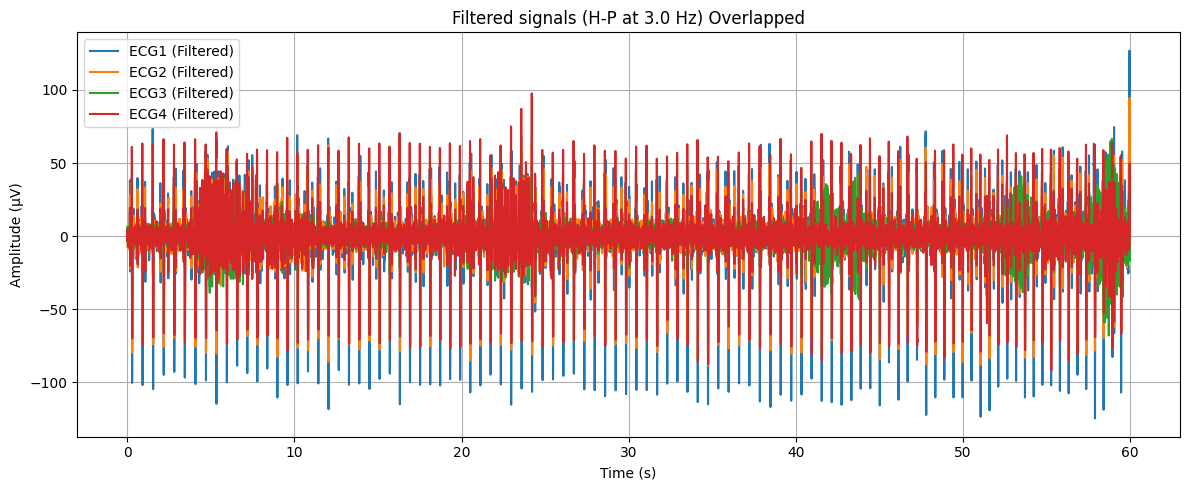

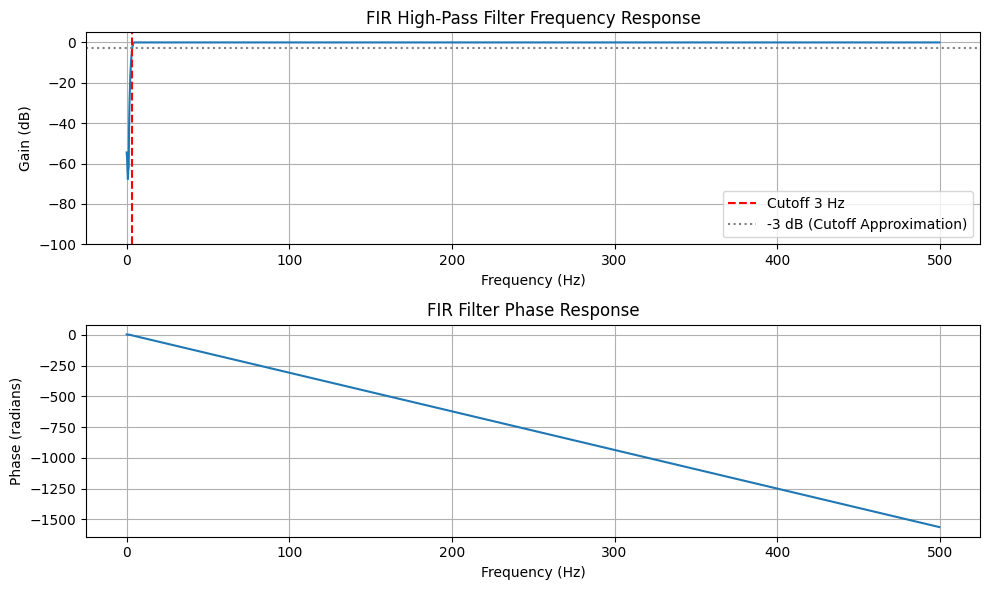

Baseline Wander Removal complete.
S1 shape: (4, 60000), S2 shape: (4, 60000)


In [49]:
FC_HP = 3.0

S2, TAPS = highpass_fir(S1, fs=fs, fc=FC_HP, numtaps=1001)

plot_filtered(S1, S2, time, fc=FC_HP)

plot_filter_response(TAPS, fs)

print("Baseline Wander Removal complete.")
print(f"S1 shape: {S1.shape}, S2 shape: {S2.shape}")

# Fase 2: Power-line interference canceller

In this fase we remove the power-line interference that consist of a sine wave whith center frequency around 50Hz.

S2 -> S3


In [50]:
def remove_powerline_adaptive(signals, fs, mains_freqs=(50.0, 100.0, 150.0)):
    """
    Remove power-line interference (50 Hz and harmonics) using adaptive fitting.
    """
    out = signals.astype(float).copy()
    n_ch, n_samples = out.shape
    t = np.arange(n_samples) / fs

    for f in mains_freqs:
        w = 2 * np.pi * f # Angular frequency
        s = np.sin(w * t) # Sine component
        c = np.cos(w * t) # Cosine component
        M = np.vstack((s, c)) # Design matrix
        pinvM = np.linalg.pinv(M.T) # Moore-Penrose pseudoinverse
        coeffs = pinvM @ out.T # Least squares coefficients A and B
        estimate = (coeffs[0, None, :] * s[:, None] + coeffs[1, None, :] * c[:, None]).T # Estimated interference
        out -= estimate # Subtract estimated interference

    return out


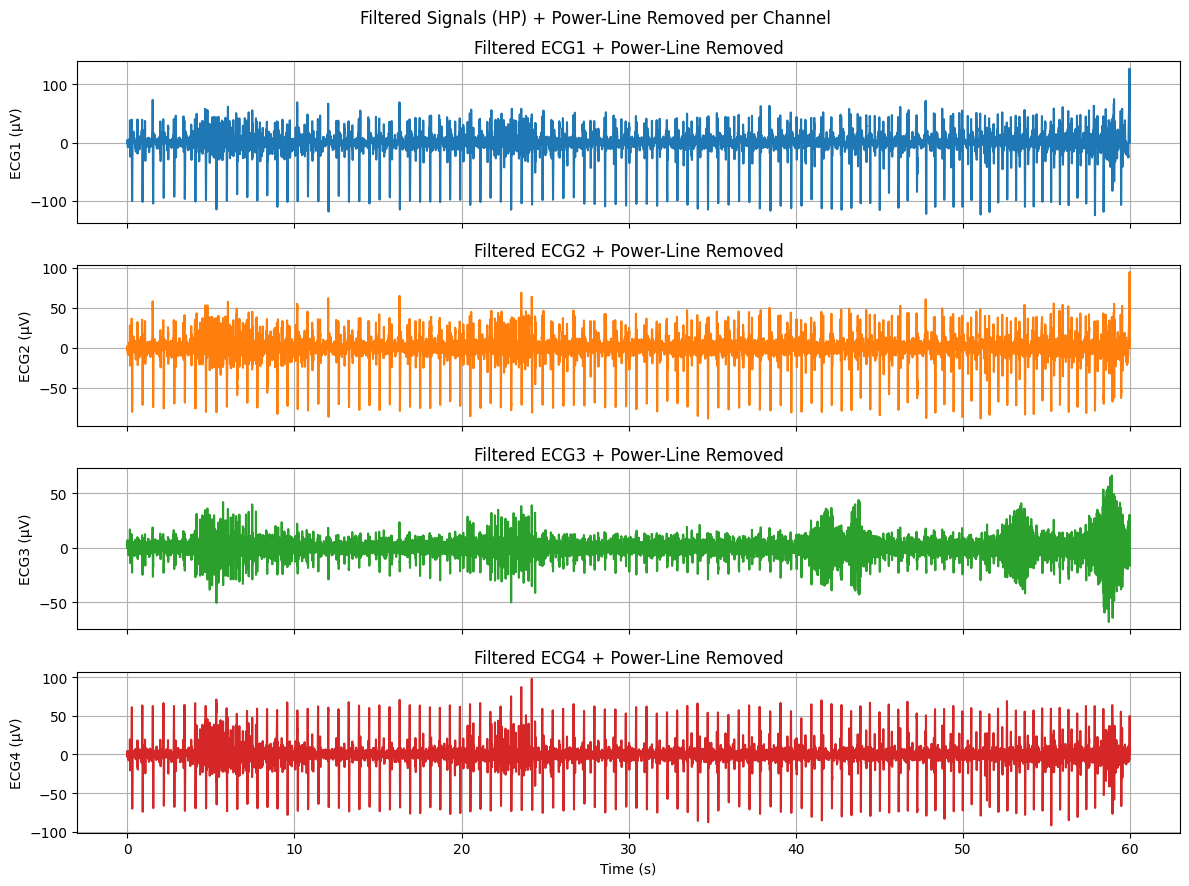

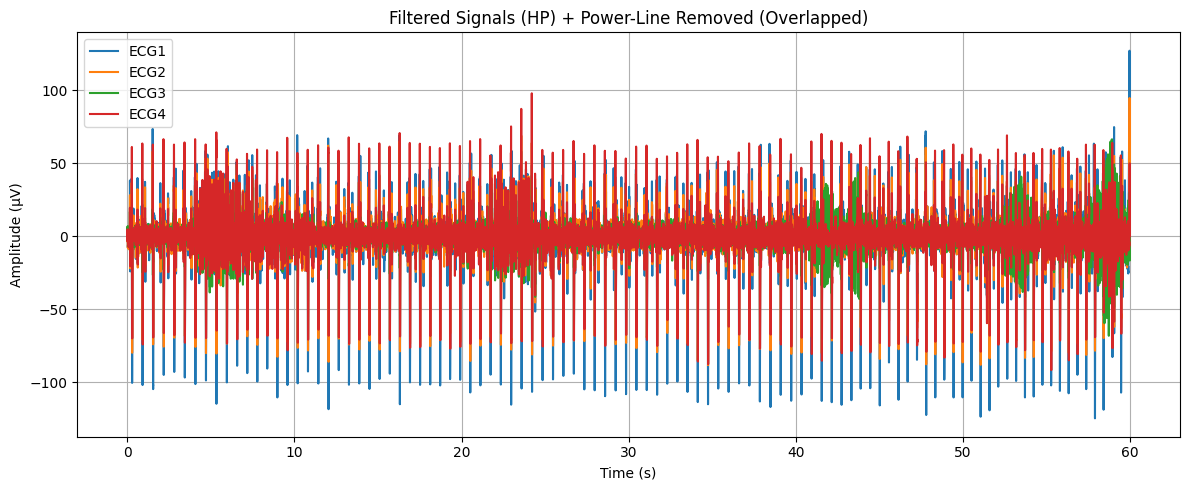

  Duration (s): 60.00


In [51]:
# Remove power-line interference
S3 = remove_powerline_adaptive(S2, fs, mains_freqs=(50, 100, 150))

ch = S3.shape[0]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]


fig, axes = plt.subplots(ch, 1, figsize=(12, 9), sharex=True)
for i in range(ch):
    axes[i].plot(time, S3[i], color=colors[i % len(colors)])
    axes[i].set_ylabel(f"ECG{i+1} (µV)")
    axes[i].grid(True)
    axes[i].set_title(f"Filtered ECG{i+1} + Power-Line Removed")
axes[-1].set_xlabel("Time (s)")
fig.suptitle("Filtered Signals (HP) + Power-Line Removed per Channel")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
for i in range(ch):
    plt.plot(time, S3[i], color=colors[i % len(colors)], label=f"ECG{i+1}")
plt.title("Filtered Signals (HP) + Power-Line Removed (Overlapped)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"  Duration (s): {S3.shape[1] / fs:.2f}")

# 3 Upsample

In this phase we upsample the signal incrased from 1000 Hz to 2000 Hz.

S3 -> S4

In [52]:
# Function for upsampling signals
def upsample_to_2000Hz(signals, fs, target_fs=2000):
    """
    Upsample signals (shape n_ch, n_samples) to target_fs (default 2000 Hz).
    
    Parameters:
    signals   : array (channels x samples)
    fs        : original sampling frequency
    target_fs : desired sampling frequency (default 2000 Hz)
    
    Returns:
    up : array (channels x new_samples) - upsampled signals
    target_fs : new sampling frequency
    """
    if fs == target_fs:
        return signals.copy(), fs
    
    n_ch, n_samples = signals.shape
    new_samples = int(round(n_samples * target_fs / fs))
    up = np.zeros((n_ch, new_samples), dtype=float)
    
    for i in range(n_ch):
        up[i] = resample(signals[i], new_samples)
    
    return up, target_fs

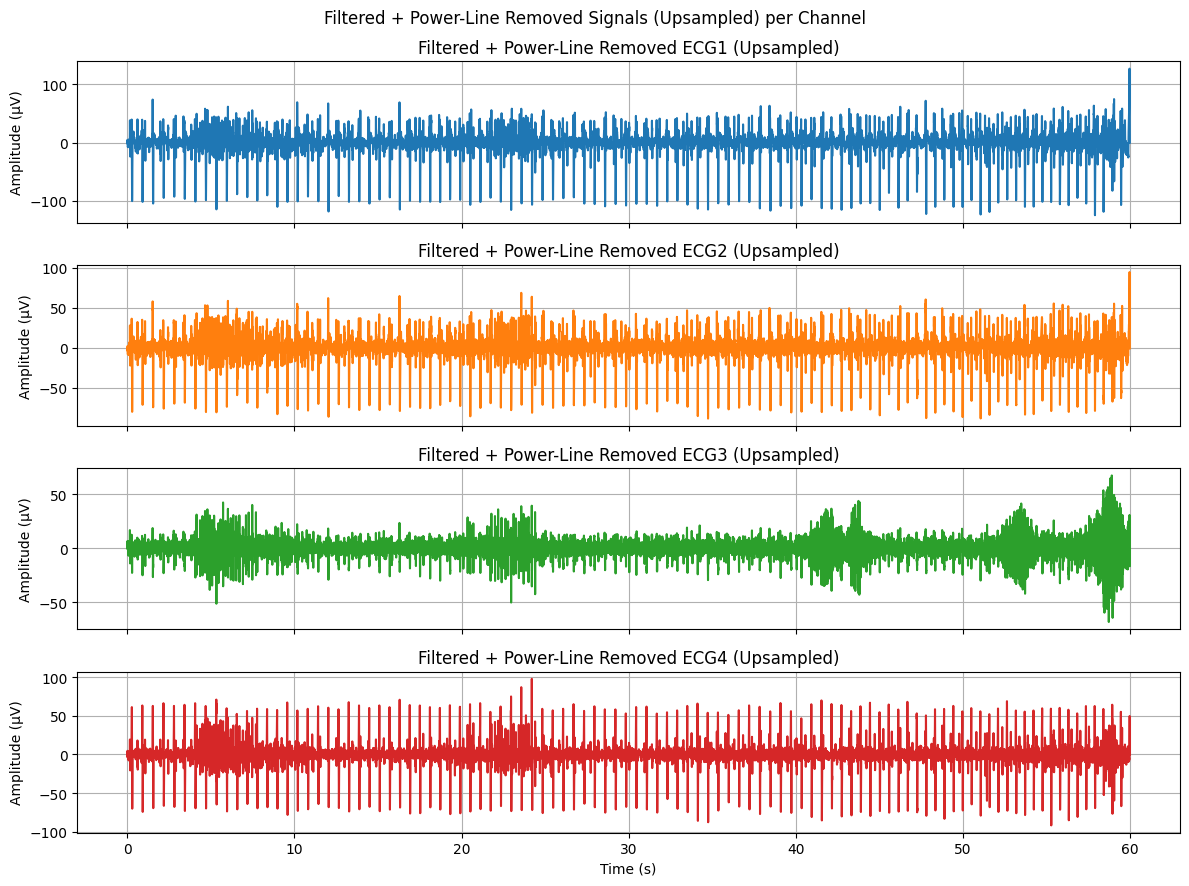

Original S3 signal: 60000 samples at 1000 Hz
Duration S3: 60.00 seconds
Upsampled S4 signal: 120000 samples at 2000 Hz
Duration S4: 60.00 seconds


In [53]:
# Upsample ⬆️


TARGET_FS = 2000
S4, fs_up = upsample_to_2000Hz(S3, fs, target_fs=TARGET_FS)
n_ch = S4.shape[0]
time_upsampled = np.arange(S4.shape[1]) / fs_up  # Nuovo asse temporale

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]


fig, axes = plt.subplots(n_ch, 1, figsize=(12, 9), sharex=True)
for i in range(n_ch):
    axes[i].plot(time_upsampled, S4[i], color=colors[i % len(colors)], label=f"ECG{i+1}")
    axes[i].set_ylabel("Amplitude (µV)")
    axes[i].grid(True)
    axes[i].set_title(f"Filtered + Power-Line Removed ECG{i+1} (Upsampled)")

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Filtered + Power-Line Removed Signals (Upsampled) per Channel")
plt.tight_layout()
plt.show()


print(f"Original S3 signal: {S3.shape[1]} samples at {fs} Hz")
print(f"Duration S3: {S3.shape[1] / fs:.2f} seconds")

print(f"Upsampled S4 signal: {S4.shape[1]} samples at {fs_up} Hz")
print(f"Duration S4: {S4.shape[1] / fs_up:.2f} seconds") 

# Fase 4: MQRS detection

I detect the Maternal QRS. 

S4 trasformation

In [54]:
def clean_nan_channels(signals):
    """
    Replace NaN/Inf in each channel with interpolated values.
    """
    signals_clean = signals.copy()
    n_ch, n_samples = signals_clean.shape
    
    for i in range(n_ch):
        y = signals_clean[i].astype(float)
        x = np.arange(n_samples)
        y[np.isinf(y)] = np.nan
        isnan = np.isnan(y)
        if np.any(isnan):
            if np.all(isnan):
                y[:] = 0.0
            else:
                y[isnan] = np.interp(x[isnan], x[~isnan], y[~isnan])
        signals_clean[i] = y
    return signals_clean

def pca_first_component(X):
    """
    Robust PCA for abdominal ECG signals. Input: (n_samples, n_channels)
    Returns: first principal component (length n_samples)
    """
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    std = np.std(X, axis=0)
    good = std > 1e-8
    if np.sum(good) == 0:
        return np.zeros(X.shape[0])
    Xg = X[:, good]
    stdg = std[good]
    
    if Xg.shape[1] == 1:
        return Xg[:,0] - np.mean(Xg[:,0])
    
    Xn = Xg / stdg
    C = np.dot(Xn.T, Xn) / Xn.shape[0]
    
    try:
        eigvals, eigvecs = np.linalg.eigh(C)
    except Exception:
        C = C + 1e-6 * np.eye(C.shape[0])
        eigvals, eigvecs = np.linalg.eigh(C)
    
    v1 = eigvecs[:, np.argmax(eigvals)]
    PC1 = Xn @ v1
    PC1 = PC1 - np.mean(PC1)
    return PC1

def build_qrs_template(fs, duration_ms=100):
    """
    Generate QRS template.
    """
    dur = duration_ms / 1000.0
    n = max(3, int(round(dur * fs)))
    t = np.linspace(-dur/2, dur/2, n)
    template = -np.exp(-(t**2)/(2*(0.01**2))) + 0.5*np.exp(-(t**2)/(2*(0.015**2)))
    if np.max(np.abs(template)) > 0:
        template = template / np.max(np.abs(template))
    return template

def mild_highpass(sig, fs, cutoff=1.0):
    """
    Mild high-pass filter (1 Hz default) zero-phase.
    """
    b, a = butter(1, cutoff/(fs/2), btype='high')
    return filtfilt(b, a, sig)

def detect_qrs_crosscorr(signal, template, fs, thr_percentile=98, refractory_s=0.28, refine_window_s=0.02):
    """
    QRS detection using cross-correlation with template.
    """
    corr = correlate(signal, template, mode='same')
    thr = np.percentile(corr, thr_percentile)
    cand = np.where(corr > thr)[0]
    
    refr = int(round(refractory_s * fs))
    w = int(round(refine_window_s * fs))
    
    qrs = []
    last = -10_000_000
    for c in cand:
        if c - last < refr:
            continue
        st = max(0, c - w)
        en = min(len(corr), c + w + 1)
        peak = st + np.argmax(corr[st:en])
        qrs.append(peak)
        last = peak
    return np.array(qrs, dtype=int), corr

def maternal_qrs_detection(signals, fs, qrs_template=None, target_fs=2000, return_converted=True, already_upsampled=False):
    """
    Complete pipeline for maternal QRS detection (using already_upsampled=True for S4).
    """
    signals_clean = clean_nan_channels(signals)
    if not already_upsampled:
        up, fs2 = upsample_to_2000Hz(signals_clean, fs, target_fs=target_fs)
    else:
        up = signals_clean
        fs2 = fs
    S = up.T
    pc1 = pca_first_component(S)
    pc1 = mild_highpass(pc1, fs2, cutoff=1.0) # 1 Hz cutoff for MECG
    if qrs_template is None:
        template = build_qrs_template(fs2)
    else:
        template = qrs_template
    mqrs_up, corr = detect_qrs_crosscorr(pc1, template, fs2, thr_percentile=98, refractory_s=0.28, refine_window_s=0.02)
    
    if return_converted and not already_upsampled:
        factor = fs / fs2
        mqrs_orig = np.unique(np.round(mqrs_up * factor).astype(int))
    else:
        mqrs_orig = None
    
    return mqrs_up, mqrs_orig, fs2, pc1, corr, template


Detected MQRS: 102


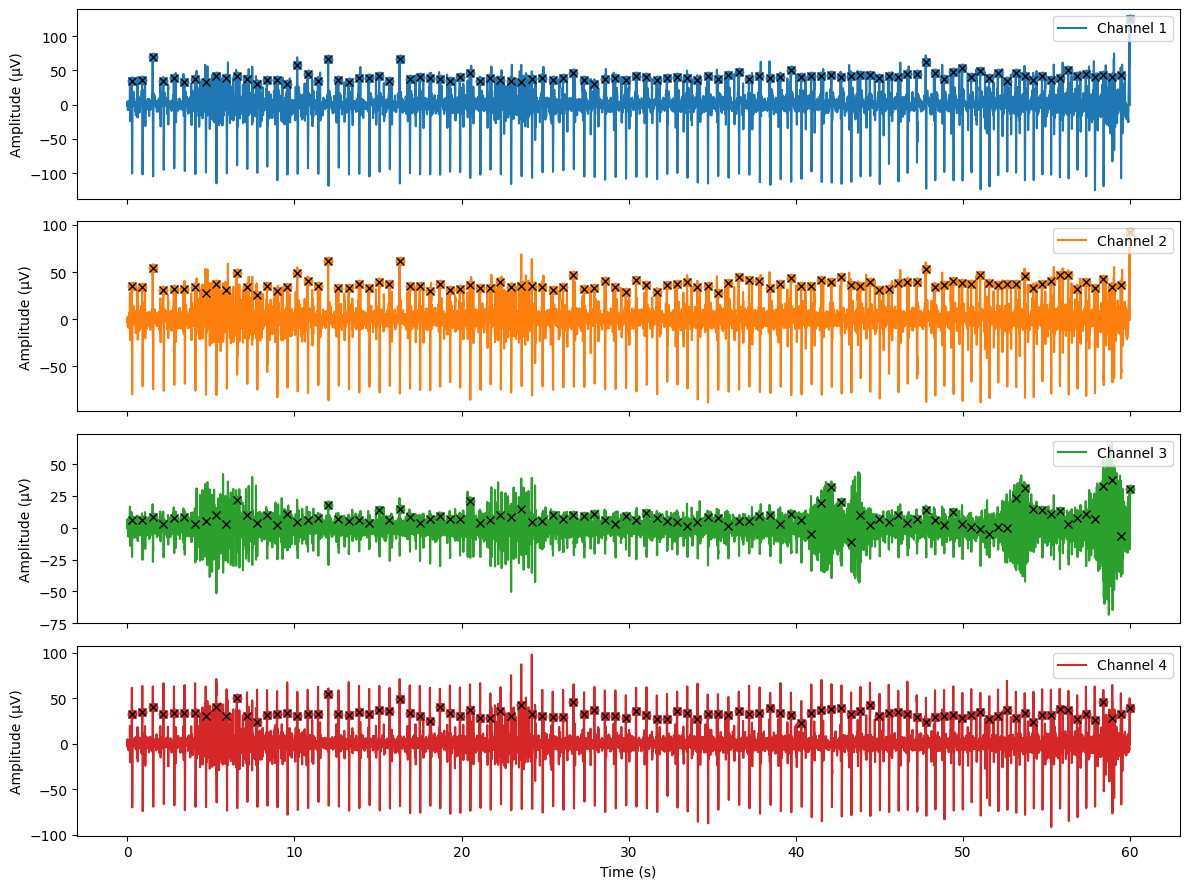

In [55]:
# MQRS detector

mqrs_up, mqrs_orig, fs2, pc1, corr, template = maternal_qrs_detection(
    S4, fs_up, already_upsampled=True
)

print(f"Detected MQRS: {len(mqrs_up)}")

time_up = np.arange(S4.shape[1]) / fs2
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, axes = plt.subplots(S4.shape[0], 1, figsize=(12, 9), sharex=True)
for i in range(S4.shape[0]):
    c = colors[i % len(colors)]
    axes[i].plot(time_up, S4[i], color=c, label=f"Channel {i+1}")
    # Plot R-peaks
    axes[i].plot(mqrs_up/fs2, S4[i, mqrs_up], 'o', color=c)
    axes[i].plot(mqrs_up/fs2, S4[i, mqrs_up], 'x', color='black')
    axes[i].legend(loc='upper right')
    axes[i].set_ylabel("Amplitude (µV)")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


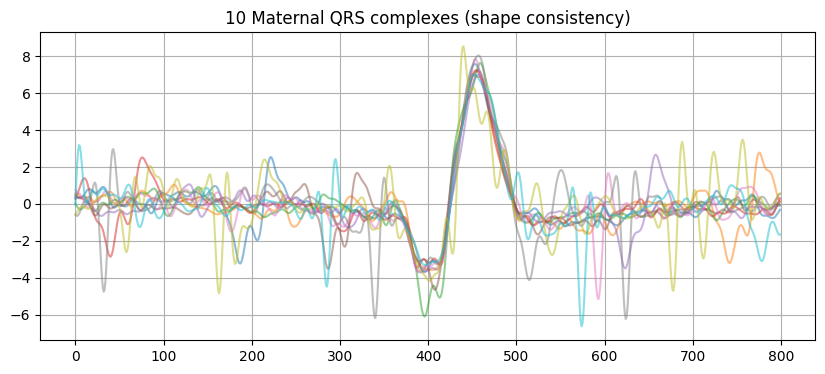

In [56]:
# Plot consistency of QRS complexes
w = int(0.2 * fs_up)  # 200ms
segs = []
for q in mqrs_up[:10]:
    if q-w > 0 and q+w < len(pc1):
        segs.append(pc1[q-w:q+w])

plt.figure(figsize=(10,4))
for s in segs:
    plt.plot(s, alpha=0.5)
plt.title("10 Maternal QRS complexes (shape consistency)")
plt.grid(True)
plt.show()

# Fase 5: MECG cancellation

I remove the MECG.

S4 -> S5

In [57]:
def mecg_cancellation(qrs_locs, ECG, fs, N=10):
    """
    Maternal ECG (MECG) canceller with separate scaling for P/QRS/T waves.
    """
    ECG_clean = ECG.copy()
    seg_len = int(0.25*fs + 0.45*fs)
    
    for i, r_peak in enumerate(qrs_locs):
        if r_peak - int(0.25*fs) < 0 or r_peak + int(0.45*fs) > len(ECG):
            continue
        
        idx_start = max(0, i-N)
        idx_cycles = qrs_locs[idx_start:i]
        if len(idx_cycles) == 0: continue
        
        MECG_matrix = []
        for p in idx_cycles:
            seg = ECG[p - int(0.25*fs) : p + int(0.45*fs)]
            if len(seg) == seg_len: MECG_matrix.append(seg)
        if len(MECG_matrix) == 0: continue
        MECG_mean = np.mean(np.array(MECG_matrix), axis=0)
        
        P_end   = int(0.20*fs)
        QRS_start = int(0.25*fs - 0.05*fs)
        QRS_end   = int(0.25*fs + 0.05*fs)
        T_start = int(0.25*fs + 0.10*fs)
        T_end   = seg_len
        
        M = np.zeros((seg_len, 3))
        M[0:P_end, 0] = MECG_mean[0:P_end]
        M[QRS_start:QRS_end, 1] = MECG_mean[QRS_start:QRS_end]
        M[T_start:T_end, 2] = MECG_mean[T_start:T_end]
        
        segment = ECG[r_peak - int(0.25*fs) : r_peak + int(0.45*fs)]
        if len(segment) != seg_len: continue
        a, _, _, _ = np.linalg.lstsq(M, segment, rcond=None)
        
        ECG_clean[r_peak - int(0.25*fs) : r_peak + int(0.45*fs)] -= M @ a
        
    return ECG_clean

def remove_mecg_multichannel(signals, qrs_locs, fs, N=10):
    """
    Apply MECG cancellation to each channel of a multi-channel ECG signal.
    """
    n_ch = signals.shape[0]
    signals_clean = np.zeros_like(signals)
    
    for i in range(n_ch):
        signals_clean[i] = mecg_cancellation(qrs_locs, signals[i], fs, N)
    
    return signals_clean

Using maternal QRS peaks detected in Phase 3: 102


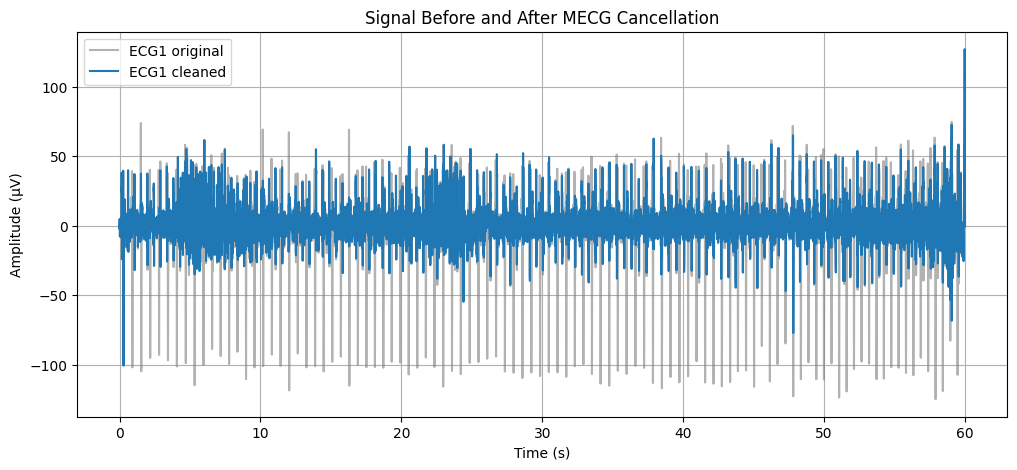

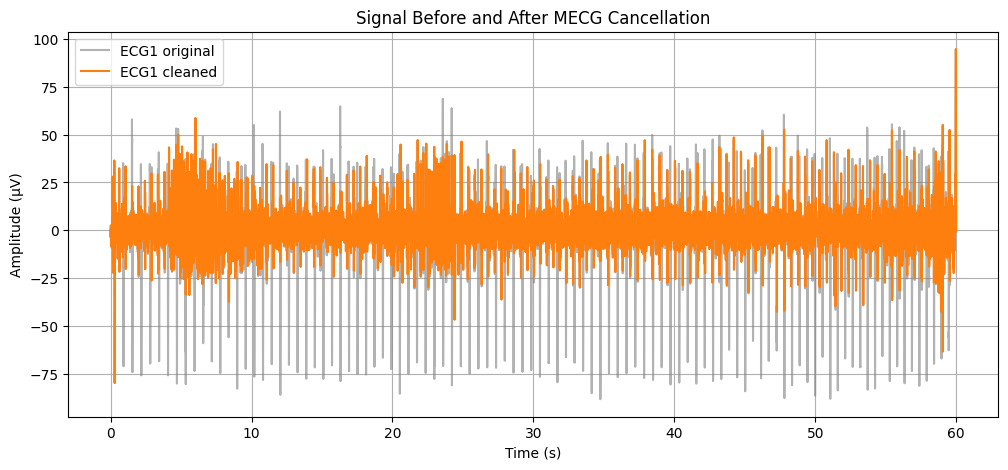

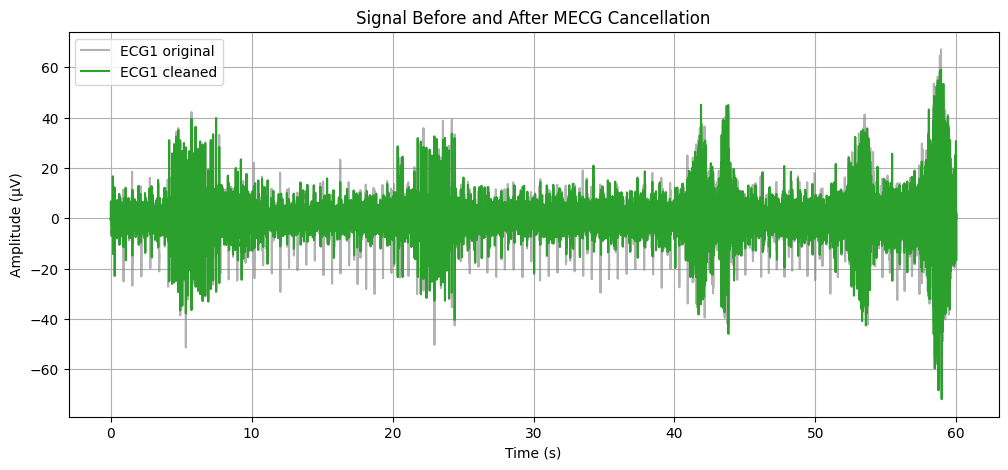

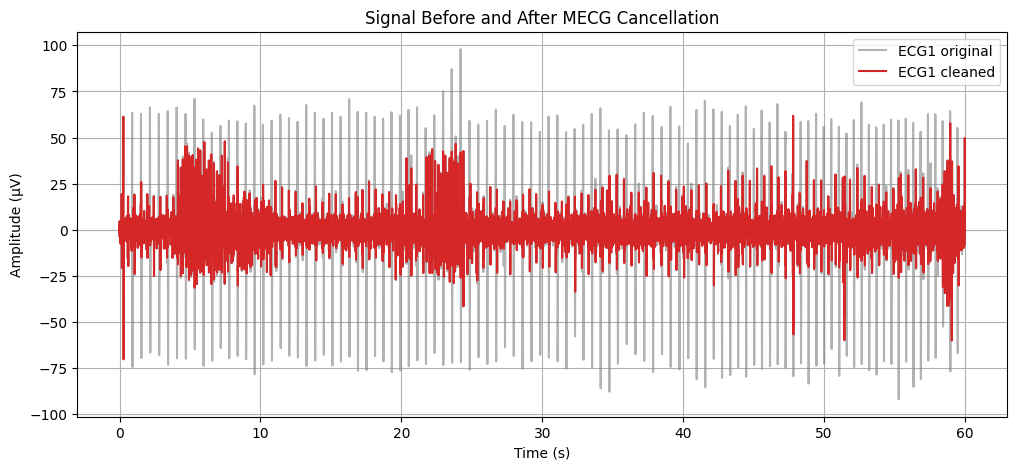

Signal S5 (upsampled + MECG removed) shape: (4, 120000)


In [58]:
# MECG cancellation

print("Using maternal QRS peaks detected in Phase 3:", len(mqrs_up))


S5 = remove_mecg_multichannel(S4, mqrs_up, fs2)

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

for i in range(S5.shape[0]):
    plt.figure(figsize=(12, 5))
    plt.plot(time_up, S4[i], label="ECG1 original", color="gray", alpha=0.6)
    plt.plot(time_up, S5[i], label="ECG1 cleaned", color=colors[i % len(colors)])
    plt.title("Signal Before and After MECG Cancellation")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.legend()
    plt.show()


print("Signal S5 (upsampled + MECG removed) shape:", S5.shape)

In [59]:
print("Original signal S4 (upsampled):")
print(f"  Number of samples: {S4.shape[1]}, fs: {fs_up} Hz")
print(f"  Duration (s): {S4.shape[1] / fs_up:.2f}")

print("Signal S5 (upsampled + MECG removed):")
print(f"  Number of samples: {S5.shape[1]}, fs: {fs2} Hz")
print(f"  Duration (s): {S5.shape[1] / fs2:.2f}")


Original signal S4 (upsampled):
  Number of samples: 120000, fs: 2000 Hz
  Duration (s): 60.00
Signal S5 (upsampled + MECG removed):
  Number of samples: 120000, fs: 2000 Hz
  Duration (s): 60.00


In [60]:

CANALE_DA_SONIFICARE = 0 
OUTPUT_FILE_S5 = "S5_FECG_sonified_a14.wav"

print("\n--- Start sonification of S5 ---")

sonify_ecg(S5, fs=fs2, channel_index=CANALE_DA_SONIFICARE, output_filename=OUTPUT_FILE_S5)

print("Sonification comolete. File saved as:", OUTPUT_FILE_S5)



--- Start sonification of S5 ---
Audio file saved as: S5_FECG_sonified_a14.wav (Duration unchanged, pitch increased)
Sonification comolete. File saved as: S5_FECG_sonified_a14.wav


# Fase 6: FQRS detection

In this phase I detect the QRS for the signal resulted by the MECG cancellation in order to discover the FECG.

S5 trasformation

In [62]:
def fetal_qrs_detection(signals, fs, qrs_template=None, target_fs=2000,
                        return_converted=True, already_upsampled=False):
    """
    Complete pipeline for fetal QRS detection.
    Identical to the maternal pipeline, but with parameters adapted
    to FECG physiology (smaller amplitude, narrower QRS, higher heart rate).
    """

    signals_clean = clean_nan_channels(signals)
    
    if not already_upsampled:
        up, fs2 = upsample_to_2000Hz(signals_clean, fs, target_fs=target_fs)
    else:
        up = signals_clean
        fs2 = fs
    
    S = up.T  
    
    pc1 = pca_first_component(S)

    pc1 = mild_highpass(pc1, fs2, cutoff=4.0)
    
    if qrs_template is None:
        template = build_qrs_template(fs2)
    else:
        template = qrs_template
    
    fqrs_up, corr = detect_qrs_crosscorr(pc1, template, fs2,
                                         thr_percentile=96,     
                                         refractory_s=0.12,      
                                         refine_window_s=0.015) 
    
    if return_converted and not already_upsampled:
        factor = fs / fs2
        fqrs_orig = np.unique(np.round(fqrs_up * factor).astype(int))
    else:
        fqrs_orig = None
    
    return fqrs_up, fqrs_orig, fs2, pc1, corr, template


In [63]:

fqrs_up, fqrs_orig, fs2, pc1, corr, template = fetal_qrs_detection(
    S5, fs_up, already_upsampled=True
)

print(f"Number of FQRS detected: {len(fqrs_up)}\n")
print(f"FQRS detected: {(fqrs_up)}")


Number of FQRS detected: 128

FQRS detected: [   306    637   1208   2113   3941   4862   5783   6712   7639   8559
   9288  10393  11138  12031  13007  14056  14502  14959  15866  16755
  17650  18472  19295  20143  21213  22122  23067  24033  25003  25962
  26925  27882  28822  29754  30699  31635  33536  34483  35413  36353
  37313  38269  39241  40189  41153  42117  43082  43563  44066  44784
  45054  46018  46966  47710  48184  48853  49803  50747  51689  52621
  53560  54497  55423  56355  57274  58198  59129  60052  60965  61878
  62792  63520  65594  66550  67538  68377  69552  70559  71597  72638
  73698  74768  75811  76864  77920  79003  79905  81163  82226  83288
  85362  86396  87420  88438  89466  90486  91509  92515  93525  94515
  95591  96541  97537  98563  99583 100596 101623 102659 102928 103675
 104722 105752 106778 107785 108825 109845 110701 111734 113026 114072
 115111 116118 116913 117453 117753 117987 119068 119872]


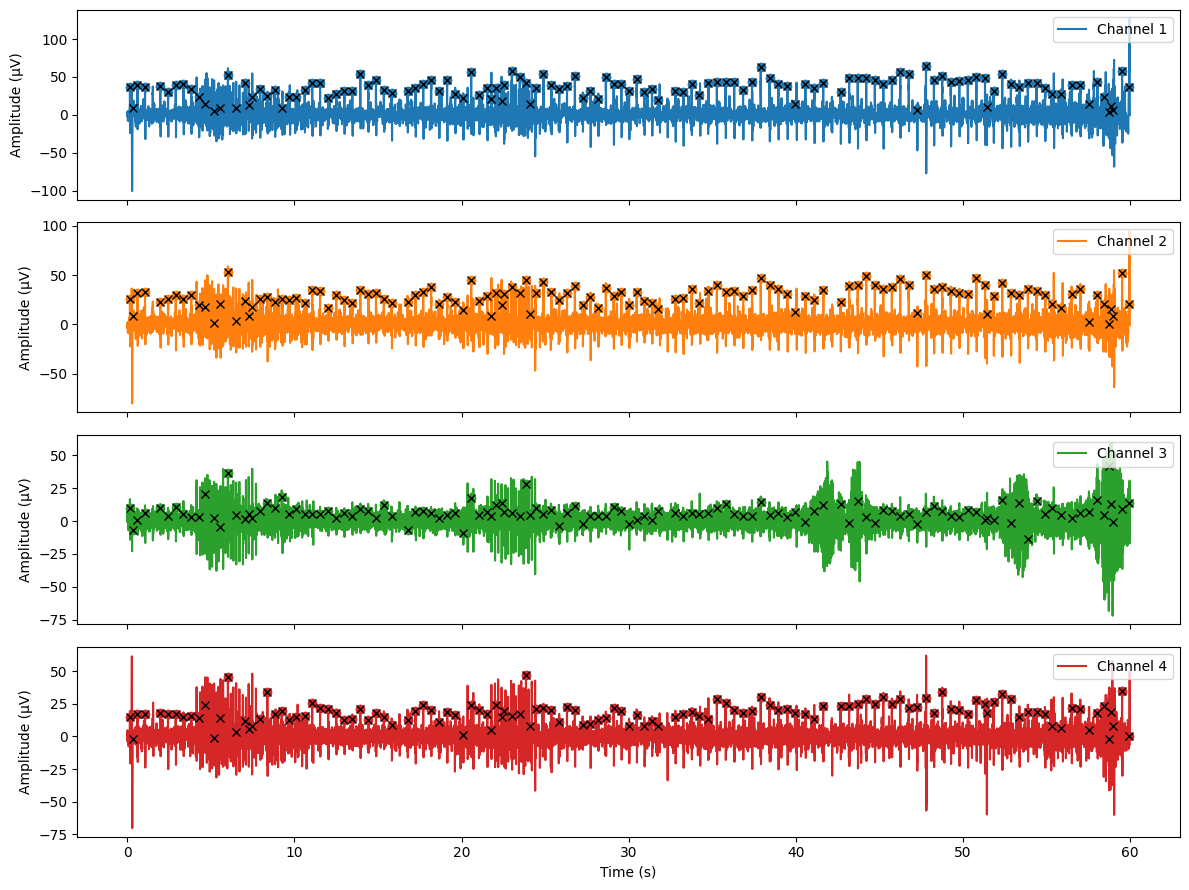

In [71]:
# print FQRS locations on all channels of the S5 signal
time_up = np.arange(S5.shape[1]) / fs2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, axes = plt.subplots(S5.shape[0], 1, figsize=(12, 9), sharex=True)

for i in range(S5.shape[0]):
    c = colors[i % len(colors)]
    axes[i].plot(time_up, S5[i], color=c, label=f"Channel {i+1}")
    # Plot FQRS peaks
    axes[i].plot(fqrs_up/fs2, S5[i, fqrs_up], 'o', color=c)
    axes[i].plot(fqrs_up/fs2, S5[i, fqrs_up], 'x', color='black')
    axes[i].legend(loc='upper right')
    axes[i].set_ylabel("Amplitude (µV)")
axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [65]:
# calculation and printing of Fetal Heart Rate (FHR)

rr_intervals_samples = np.diff(fqrs_up)

rr_intervals_seconds = rr_intervals_samples / fs2


if len(rr_intervals_seconds) > 0:
    rr_mean_seconds = np.mean(rr_intervals_seconds)
    
    fhr_bpm = 60 / rr_mean_seconds
    
    print(f"Mean R-R Interval: {rr_mean_seconds * 1000:.2f} ms")
    print(f"Estimated Fetal Heart Rate (FHR): {fhr_bpm:.2f} BPM")
else:
    print("Not enough FHR estimated.")

Mean R-R Interval: 470.73 ms
Estimated Fetal Heart Rate (FHR): 127.46 BPM


# Fase 7: FECG Detection

In this phase I plot the result of the FECG detection.

S5 -> S6


In [66]:
# w = int(0.2 * fs_up)  # 200ms
# segs = []

# for q in fqrs_up[:10]:
#     if q-w > 0 and q+w < len(pc1):
#         segs.append(pc1[q-w:q+w])

# plt.figure(figsize=(10,4))
# for s in segs:
#     plt.plot(s, alpha=0.5)
# plt.title("10 Fetal QRS complexes (shape consistency)")
# plt.grid(True)
# plt.show()

S6 shape (Average FECG per channel): (4, 800)


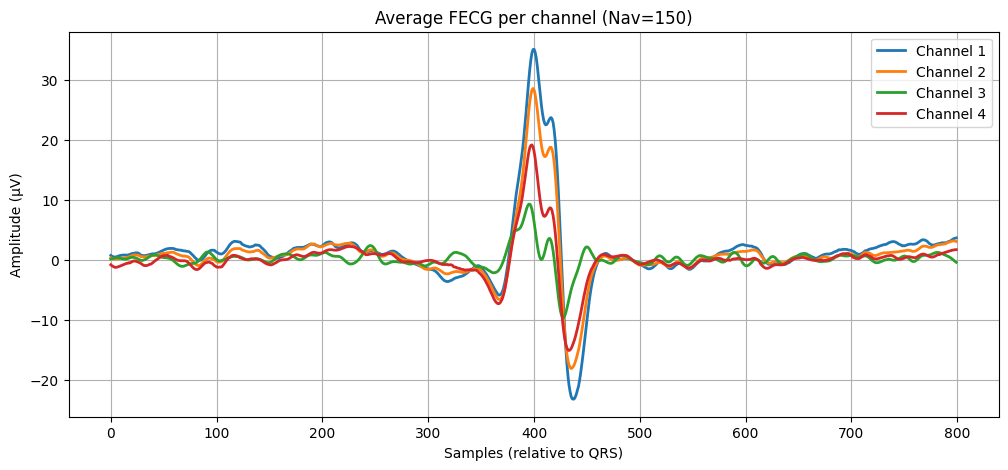

In [67]:
# FECG Detection & Evaluation

w = int(0.2 * fs2)  
num_channels = S5.shape[0]
Nav = 150  
S6 = []

for ch in range(num_channels):
    segments = []
    for q in fqrs_up[:Nav]:  
        if q - w > 0 and q + w < S5.shape[1]:
            segments.append(S5[ch, q-w:q+w])
    segments_array = np.array(segments)
    mean_segment = segments_array.mean(axis=0)
    S6.append(mean_segment)

S6 = np.array(S6)
print(f"S6 shape (Average FECG per channel): {S6.shape}")


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
plt.figure(figsize=(12,5))
for ch in range(num_channels):
    plt.plot(S6[ch], color=colors[ch], linewidth=2, label=f"Channel {ch+1}")
plt.title("Average FECG per channel (Nav=150)")
plt.xlabel("Samples (relative to QRS)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.legend()
plt.show()

# Performance matrics

In [76]:
def power_per_channel(signal):
    return np.mean(signal**2, axis=1)

def compute_snr(S5, S6):
    """
    SNR_j = PS6,j / (PS5,j - PS6,j)
    """
    S5, S6 = map(np.asarray, (S5, S6))
    PM = S5 - S6 
    return S6 / PM

def compute_sir(S4, S5, S6):
    """
    SIR_j = PS6,j / (PS4,j - PS5,j)
    """
    S4, S5, S6 = map(np.asarray, (S4, S5, S6))
    PN = S4 - S5 
    return S6 / PN

S4_pow = power_per_channel(S4)
S5_pow = power_per_channel(S5)
S6_pow = power_per_channel(S6)

snr = compute_snr(S5_pow, S6_pow)
sir = compute_sir(S4_pow, S5_pow, S6_pow)

print("SNR:", snr)
print("SIR:", sir)

SNR: [0.69459445 0.65001412 0.06377954 0.43403153]
SIR: [0.14488522 0.15233176 0.19828599 0.06968844]


In [69]:
# Performance Metrics (Comparison with Annotations)

fqrs_file = "a14.fqrs.txt"
fQRS_orig = np.loadtxt(fqrs_file, dtype=int)


fs_orig = fs
fs_fecg = fs2
factor = fs_fecg / fs_orig
fQRS = np.unique(np.round(fQRS_orig * factor).astype(int))


tolerance_ms = 50
tolerance_samples = int(tolerance_ms / 1000 * fs_fecg)


true_positives = 0
for f_qrs in fQRS:
    if np.any(np.abs(fqrs_up - f_qrs) <= tolerance_samples):
        true_positives += 1


false_positives = len(fqrs_up) - true_positives
false_negatives = len(fQRS) - true_positives
sensitivity = true_positives / len(fQRS)
ppv = true_positives / len(fqrs_up)
f1_score = 2 * sensitivity * ppv / (sensitivity + ppv) if (sensitivity + ppv) > 0 else 0.0
accuracy = true_positives / (true_positives + false_positives + false_negatives)


print("\n===== FQRS Detection Performance =====")
print(f"Detected FQRS:             {len(fqrs_up)}")
print(f"Annotated FQRS (upsampled): {len(fQRS)}")
print(f"True Positives (±{tolerance_ms} ms): {true_positives}")
print(f"False Positives:           {false_positives}")
print(f"False Negatives:           {false_negatives}")
print(f"Sensitivity:               {sensitivity:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(f"F1-score:                  {f1_score:.3f}")
print(f"Approximate Accuracy:      {accuracy:.3f}")
print("=====================================")


# FHR Detection Reliability
if len(rr_intervals_seconds) > 0:
    beat_times = np.cumsum(rr_intervals_seconds)  

    fhr_trace_bpm = 60 / rr_intervals_seconds

    block_duration_seconds = 10

    start_time = 0
    end_time = beat_times[-1]

    outliers = 0
    total_points = len(fhr_trace_bpm)

    current_start = start_time
    while current_start < end_time:
        current_end = current_start + block_duration_seconds
        indices_in_window = np.where((beat_times >= current_start) & (beat_times < current_end))[0]
        block = fhr_trace_bpm[indices_in_window]
        if len(block) > 0:
            median_block = np.median(block)
            outliers += np.sum(np.abs(block - median_block) > 10)
        current_start = current_end

    fhr_reliability = 1 - outliers / total_points
    print(f"FHR detection reliability: {fhr_reliability*100:.2f}%")
else:
    print("Not enough FQRS for the FHR reliability.")


===== FQRS Detection Performance =====
Detected FQRS:             128
Annotated FQRS (upsampled): 123
True Positives (±50 ms): 105
False Positives:           23
False Negatives:           18
Sensitivity:               0.854
Positive Predictive Value (PPV): 0.820
F1-score:                  0.837
Approximate Accuracy:      0.719
FHR detection reliability: 68.50%
